# Code lab for Skripsi (Refined)

This branch implements the real world scenario of feature selection-train-cross validate-test sequence, so that the validation data does not get leaked by the feature selection method.

Feature extraction part is done in `deep_feature_extractior.ipynb` files. This file is used to feature selection and train model

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV
from sklearn import metrics

import joblib

In [6]:
df = pd.read_parquet('data/extracted_stem_image_feature.parquet')
df.head()

,file_name,resnet_1,resnet_2,resnet_3,resnet_4,resnet_51200,is_infected
0,DSC03983_4.JPG,0.0,0.000000,0.0,0.0,0.000000,1
1,DSC03983_6.JPG,0.0,0.746624,0.0,0.0,0.000000,1
2,DSC03984_3.JPG,0.0,0.000000,0.0,0.0,0.145803,1
3,DSC03984_4.JPG,0.0,1.093921,0.0,0.0,0.000000,1
4,DSC03984_6.JPG,0.0,0.558325,0.0,0.0,0.000000,1


In [9]:
df.drop(columns=['file_name'], inplace=True)
label = df.pop('is_infected')

,file_name,resnet_1,resnet_2,resnet_3,resnet_4,resnet_51200,is_infected


In [11]:
df.head()

,file_name,resnet_1,resnet_2,resnet_3,resnet_4,resnet_51200,is_infected
1000,DSC03977_4.JPG,0.554849,0.000000,4.649619,0.000000,0.0,0
1001,DSC03977_5.JPG,12.543129,0.000000,6.944101,0.000000,0.0,0
1002,DSC03978_1.JPG,0.000000,0.000000,0.000000,0.000000,0.0,0
1003,DSC03978_2.JPG,1.163129,0.000000,0.000000,0.080410,0.0,0
1004,DSC03978_4.JPG,0.000000,0.000000,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...
1995,DSC04871_7.JPG,2.441429,1.163028,8.615595,1.732393,0.0,0
1996,DSC04871_8.JPG,0.000000,0.000000,0.000000,0.000000,0.0,0
1997,DSC04872_2.JPG,0.000000,0.000000,6.442781,0.000000,0.0,0
1998,DSC04872_7.JPG,0.000000,0.000000,0.611162,1.089532,0.0,0


In [3]:
# split data
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

## Create Pipeline

The Pipeline will select and classify features.

Feature selection is done using `sklearn.feature_selection.SelectFromModel` with `sklearn.svm.SVC` as estimator. Feature selection and classification will run inside cross-validation.

Classification is done using SVM with linear kernel.

In [4]:
svc_C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
METRICS = ['f1', 'recall', 'precision', 'accuracy']
scores_list = []

for C in svc_C:
    print('C =', C)
    svm = SVC(kernel='linear', C=C, random_state=42)
    selector = SelectFromModel(svm)
    pipeline = Pipeline([
        ('sfm', selector),
        ('svc', svm)
    ])
    scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring=METRICS, verbose=3, n_jobs=3)
    print('-------------------------\n')
    scores_list.append(scores)

In [ ]:
np.array([[i]*5 for i in svc_C]).flatten()

In [ ]:
# pd.DataFrame(scores_list[0])
score_df = pd.concat([pd.DataFrame(scores_list[i]) for i in range(len(scores_list))], axis=0)
score_df.insert(0, 'C', np.array([[i]*5 for i in svc_C]).flatten())
score_df.to_csv(r'result\score_selectfrommodel_C_cv.csv')

C = 0.001


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


In [33]:
svc_C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_result_list = []

for C in svc_C:
    print('C =', C)
    rfecv = RFECV(estimator=SVC(kernel='linear', C=C, random_state=42),
                  step=0.2,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=3)
    rfecv.fit(X_train, y_train)
    print('-------------------------\n')
    cv_result_list.append(rfecv.cv_results_)

array([1.e-03, 1.e-03, 1.e-03, 1.e-03, 1.e-03, 1.e-02, 1.e-02, 1.e-02,
       1.e-02, 1.e-02, 1.e-01, 1.e-01, 1.e-01, 1.e-01, 1.e-01, 1.e+00,
       1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+01, 1.e+01, 1.e+01, 1.e+01,
       1.e+01, 1.e+02, 1.e+02, 1.e+02, 1.e+02, 1.e+02, 1.e+03, 1.e+03,
       1.e+03, 1.e+03, 1.e+03])

In [35]:
pd.DataFrame(cv_result_list[1])

In [36]:
svm = SVC(kernel='linear', random_state=42)
selector = SelectFromModel(svm, prefit=True)
pipeline = Pipeline([
    ('sfm', selector),
    ('svc', svm)
])

C = 0.001
-------------------------

C = 0.01
-------------------------

C = 0.1
-------------------------

C = 1
-------------------------

C = 10


MemoryError: Unable to allocate 500. MiB for an array with shape (1280, 51200) and data type float64

## Hyperparameter tuning with Cross Validation

Find Hyperparameter C with cross validation and will be using k=10. Metrics being used is F1-Score, Recall, Precision, and Accuracy.

In [17]:
METRICS = ['f1', 'recall', 'precision', 'accuracy']
PARAM_GRID = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid = GridSearchCV(pipeline, cv=5, param_grid=PARAM_GRID, scoring=METRICS, refit=False, verbose=3)
grid.fit(X=X_train, y=y_train)

In [ ]:
grid.cv_results_

In [7]:
cv_result = pd.DataFrame(grid.cv_results_)
cv_result.to_csv(r'result\cv_result.csv')
cv_result

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END svc__C=0.001; accuracy: (test=0.759) f1: (test=0.760) precision: (test=0.762) recall: (test=0.758) total time= 3.3min
[CV 2/5] END svc__C=0.001; accuracy: (test=0.722) f1: (test=0.717) precision: (test=0.729) recall: (test=0.706) total time= 3.2min
[CV 3/5] END svc__C=0.001; accuracy: (test=0.762) f1: (test=0.759) precision: (test=0.769) recall: (test=0.750) total time= 3.3min
[CV 4/5] END svc__C=0.001; accuracy: (test=0.762) f1: (test=0.770) precision: (test=0.747) recall: (test=0.794) total time= 3.2min
[CV 5/5] END svc__C=0.001; accuracy: (test=0.766) f1: (test=0.760) precision: (test=0.778) recall: (test=0.744) total time= 3.2min
[CV 1/5] END svc__C=0.01; accuracy: (test=0.759) f1: (test=0.760) precision: (test=0.762) recall: (test=0.758) total time= 3.3min
[CV 2/5] END svc__C=0.01; accuracy: (test=0.722) f1: (test=0.717) precision: (test=0.729) recall: (test=0.706) total time= 3.2min
[CV 3/5] END svc__C=0.01;

KeyboardInterrupt: 

In [ ]:
cv_result[['param_svc__C', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']]

## Build and run the model

Because all metrics are the same on all C, we train it using the C that provide the least fit time, that is C=0.1

In [ ]:
best_param_svm = SVC(kernel="linear", C=0.1, random_state=42)
best_selector = SelectFromModel(best_param_svm)
new_pipeline = make_pipeline(best_selector,
                             best_param_svm)
new_pipeline.fit(X_train, y_train)

In [ ]:
joblib.dump(new_pipeline, r'dumps\pipeline.joblib')

### Calculate Threshold Manually

Train SVM on all X_train to calculate the threshold manually

In [24]:
train_svm = SVC(kernel='linear', C=0.1)
train_svm.fit(X_train, y_train)

['dumps\\pipeline.joblib']

In [ ]:
np.savetxt(r'data\svm_coef.txt', train_svm.coef_, delimiter='\n')

In [6]:
# np.loadtxt(r'data\svm_coef.txt')

SVC(C=0.1, kernel='linear')

In [7]:
print('Threshold:', np.abs(train_svm.coef_).mean())

### Get Selector and Estimator Properties

In [8]:
print('Threshold :', new_pipeline['selectfrommodel'].threshold_)

Threshold: 0.0004338664095024176


In [ ]:
print('No. selected feature :', new_pipeline['selectfrommodel'].get_feature_names_out().shape)

In [41]:
np.savetxt(r'data\svm_coef_selected.txt', new_pipeline['svc'].coef_, delimiter='\n')

Threshold : 0.0004338664095024176


## Evaluate Model

Evaluate model on test data using same metrics from cross-validation.

In [43]:
new_pipeline = joblib.load(r'dumps\pipeline.joblib')

In [ ]:
y_pred = new_pipeline.predict(X_test)
true_pred_df = pd.DataFrame({'n-th sample': np.arange(1, len(y_pred)+1),
                             'y_true': np.where(y_test == 0, 'normal', 'terinfeksi'),
                             'y_pred': np.where(y_pred == 0, 'normal', 'terinfeksi')})
true_pred_df.to_csv(r'result\true_pred.csv', index=False)
true_pred_df

In [12]:
y_pred = new_pipeline.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['normal', 'infected'], cmap='summer')

In [16]:
metrics_list = [metrics.f1_score,
                metrics.accuracy_score,
                metrics.precision_score,
                metrics.recall_score]

for metric in metrics_list:
    print(metric.__name__ + ':', metric(y_test, y_pred))

,n-th sample,y_true,y_pred
0,1,normal,normal
1,2,terinfeksi,terinfeksi
2,3,normal,normal
3,4,terinfeksi,terinfeksi
4,5,normal,normal
...,...,...,...
395,396,terinfeksi,normal
396,397,normal,normal
397,398,normal,normal
398,399,terinfeksi,terinfeksi


[[166  35]
 [ 45 154]]


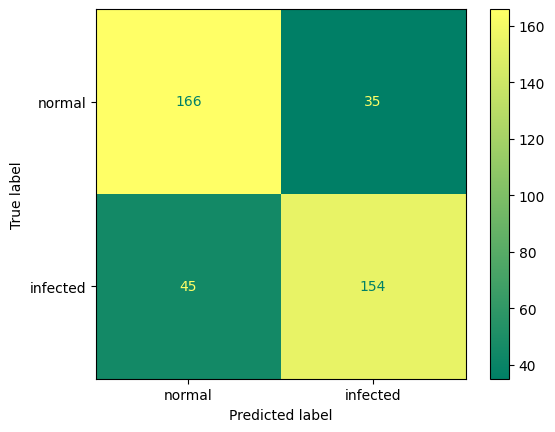

In [30]:
y_pred = new_pipeline.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['normal', 'infected'], cmap='summer')

In [33]:
metrics_list = [metrics.f1_score,
                metrics.accuracy_score,
                metrics.precision_score,
                metrics.recall_score]

for metric in metrics_list:
    print(metric.__name__ + ':', metric(y_test, y_pred))

f1_score: 0.7938144329896907
accuracy_score: 0.8
precision_score: 0.8148148148148148
recall_score: 0.7738693467336684
